# 16.32 - Redes Neuronales en Bioingeniería 

André Torvestad - Septiembre 2022


## TP1:

# **Parte 2/2: Regresión**

Partes:
1. Análisis exploratorio de datos (EDA)
2. Aplicacion de los modelos
3. Evaluacion de métricas: MSE (Mean Squared Error) 

El objecto del trabajo es crear dos modeles: un para clasificar y un para regresar. Los data sets son "*Yeast Data Set*" y "*Physicochemical Properties of Protein Tertiary Structure Data Set*". La primera para clasificación, la segunda para regresión. Primero se hacer un EDA para conocer los datos. Después, se aplican los modelos vistos en clase. Los modelos se evaluarán según la puntuación micro-macro F1 y el MSE, respectivamente. Por el clasificacion, los tres clases más distintas van a ser elegido para clasificar. También, los dos más distintas van a ser elegido por un problema binario. 


---


Bibliografía:

https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f 


Vivek, Y. (2016) *Why dropouts prevent overfitting in deep neural networks* Available from: https://vivek-yadav.medium.com/why-dropouts-prevent-overfitting-in-deep-neural-networks-937e2543a701 (Accessed: 21.09.22)


In [2]:
# Importar librarias 
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
from sklearn.decomposition import PCA

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from numpy import argmax
from IPython.display import clear_output
from sklearn.metrics import f1_score
from tensorflow import argmax as tf_argmax
from keras import backend as K
import keras 
import tensorflow as tf
!pip install tensorflow_addons
import tensorflow_addons as tfa
sns.set_theme()
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Physicochemical Properties of Protein Tertiary Structure Data Set 
Una problema de regresión. Los datos tiene 10 características: 

* RMSD-Size of the residue.
* F1 - Total surface area.
* F2 - Non polar exposed area.
* F3 - Fractional area of exposed non polar residue.
* F4 - Fractional area of exposed non polar part of residue.
* F5 - Molecular mass weighted exposed area.
* F6 - Average deviation from standard exposed area of residue.
* F7 - Euclidian distance.
* F8 - Secondary structure penalty.
* F9 - Spacial Distribution constraints (N,K Value).

Queremos predecir, con regresión, el tamaño del residuo basándonos en las características F1-9. 


### Analisis de Data

In [4]:
dt = pd.read_csv('/content/drive/MyDrive/Neural Networks/TP 1/CASP.csv')
dt.shape

(45730, 10)

In [5]:
dt.head()

,RMSD,F1,F2,F3,F4,F5,F6,F7,F8,F9
0,17.284,13558.30,4305.35,0.31754,162.1730,1.872791e+06,215.3590,4287.87,102,27.0302
1,6.021,6191.96,1623.16,0.26213,53.3894,8.034467e+05,87.2024,3328.91,39,38.5468
2,9.275,7725.98,1726.28,0.22343,67.2887,1.075648e+06,81.7913,2981.04,29,38.8119
3,15.851,8424.58,2368.25,0.28111,67.8325,1.210472e+06,109.4390,3248.22,70,39.0651
4,7.962,7460.84,1736.94,0.23280,52.4123,1.021020e+06,94.5234,2814.42,41,39.9147


In [6]:
dt.isna().sum()

RMSD    0
F1      0
F2      0
F3      0
F4      0
F5      0
F6      0
F7      0
F8      0
F9      0
dtype: int64

No tenemos valores de NaN.

In [7]:
dt.describe() # obtener las características descripticas

,RMSD,F1,F2,F3,F4,F5,F6,F7,F8,F9
count,45730.000000,45730.000000,45730.000000,45730.000000,45730.000000,4.573000e+04,45730.000000,45730.000000,45730.000000,45730.000000
mean,7.748528,9871.596995,3017.367175,0.302392,103.492433,1.368299e+06,145.638061,3989.755990,69.975071,34.523664
std,6.118312,4058.138034,1464.324663,0.062886,55.424985,5.640367e+05,69.999230,1993.574575,56.493443,5.979755
min,0.000000,2392.050000,403.500000,0.092500,10.310100,3.194902e+05,31.970400,0.000000,0.000000,15.228000
25%,2.305000,6936.680000,1979.045000,0.258740,63.563900,9.535912e+05,94.757500,3165.322500,31.000000,30.424725
50%,5.030000,8898.805000,2668.155000,0.300150,87.740800,1.237219e+06,126.176000,3840.170000,54.000000,35.299300
75%,13.379000,12126.150000,3786.410000,0.342890,133.646750,1.690920e+06,181.468500,4644.192500,91.000000,38.870800
max,20.999000,40034.900000,15312.000000,0.577690,369.317000,5.472011e+06,598.408000,105948.170000,350.000000,55.300900


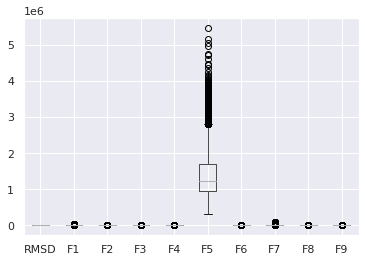

In [8]:
dt.boxplot()

Como vemos arriba, es importante scalar los datos. 

In [9]:
nrm = StandardScaler() 
nrm.fit(dt.iloc[:,1:])

dt.iloc[:,1:] = pd.DataFrame(
                              nrm.transform(dt.iloc[:,1:]),
                              columns = dt.iloc[:,1:].columns[:],
                              index=dt.iloc[:,1:].index
                            )

In [10]:
dt.describe()

,RMSD,F1,F2,F3,F4,F5,F6,F7,F8,F9
count,45730.000000,4.573000e+04,4.573000e+04,4.573000e+04,4.573000e+04,4.573000e+04,4.573000e+04,4.573000e+04,4.573000e+04,4.573000e+04
mean,7.748528,8.235024e-17,2.125568e-16,-2.257640e-16,-1.532025e-16,-7.271682e-17,2.986362e-16,-1.149019e-16,-5.344997e-17,-5.835991e-16
std,6.118312,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00
min,0.000000,-1.843118e+00,-1.785052e+00,-3.337702e+00,-1.681252e+00,-1.859489e+00,-1.623859e+00,-2.001330e+00,-1.238654e+00,-3.226867e+00
25%,2.305000,-7.232255e-01,-7.090870e-01,-6.941525e-01,-7.204146e-01,-7.352577e-01,-7.268811e-01,-4.135499e-01,-6.899119e-01,-6.854768e-01
50%,5.030000,-2.397165e-01,-2.384826e-01,-3.565041e-02,-2.842004e-01,-2.323987e-01,-2.780355e-01,-7.503488e-02,-2.827805e-01,1.297118e-01
75%,13.379000,5.555695e-01,5.251918e-01,6.440013e-01,5.440623e-01,5.719920e-01,5.118746e-01,3.282765e-01,3.721699e-01,7.269836e-01
max,20.999000,7.432875e+00,8.396203e+00,4.377792e+00,4.796167e+00,7.275692e+00,6.468284e+00,5.114408e+01,4.956823e+00,3.474634e+00


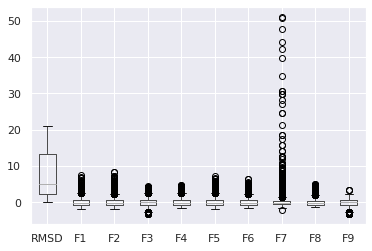

In [11]:
dt.boxplot()

Vemos que ahora los datos son normalisado alrededor de cero, pero que hay muchas valores en F7 que son muy altas. 

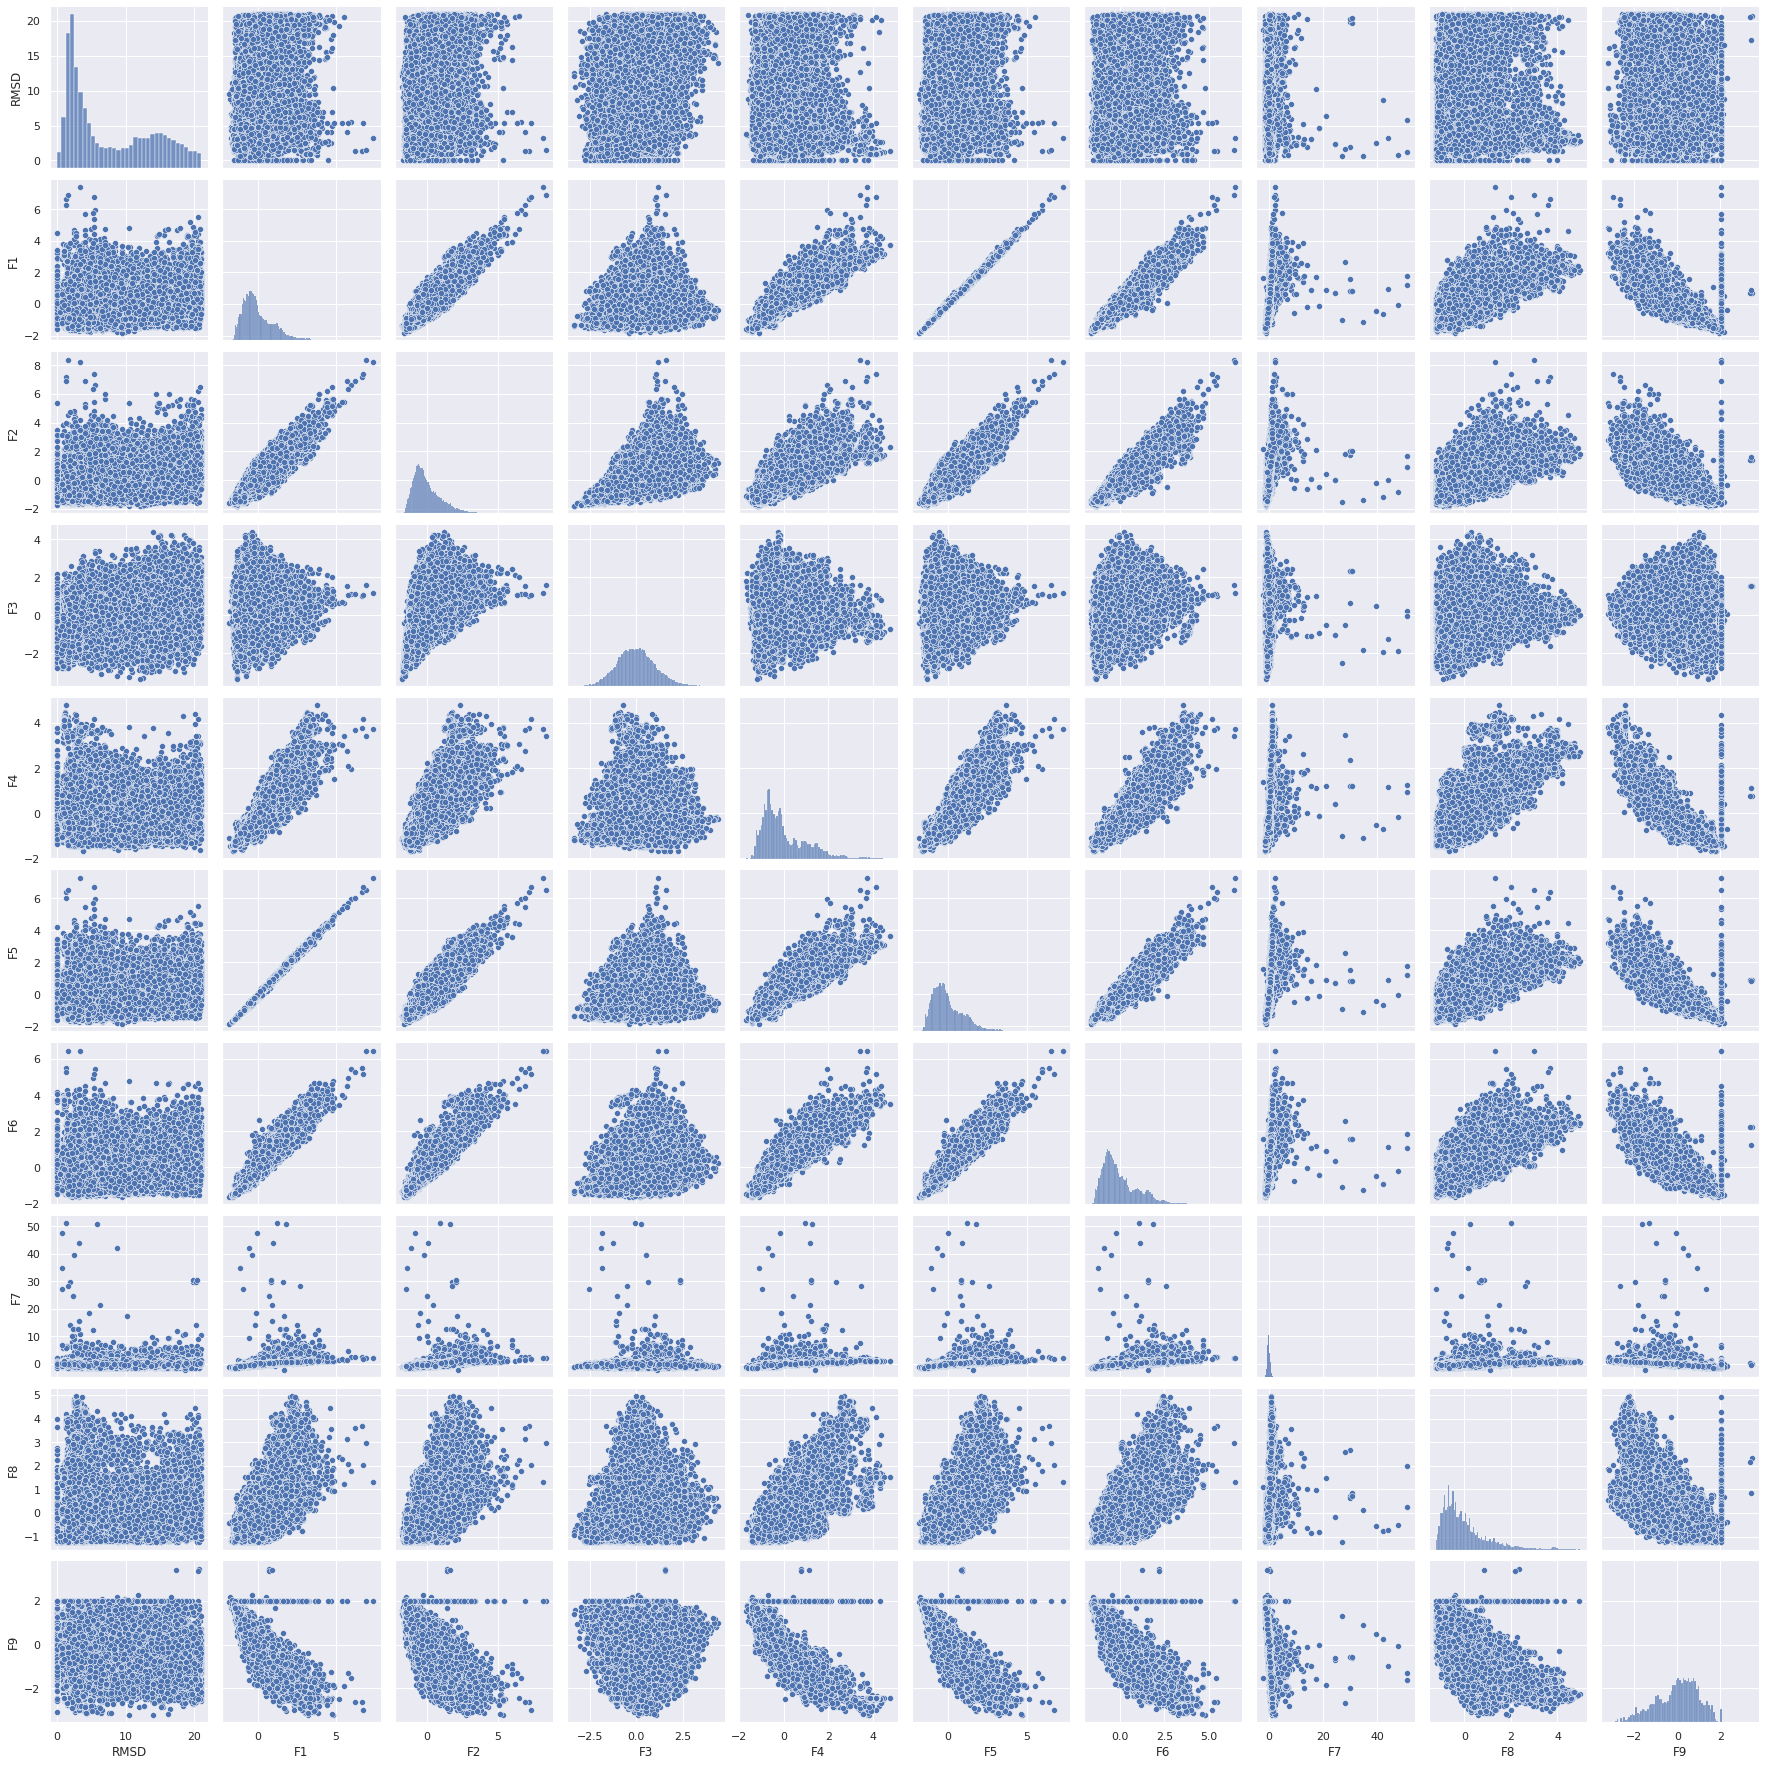

In [12]:
sns.pairplot(dt)

Vemos en el pairplot que no hay un feature que único es muy correlado con RMSD. Pero hay features que son correlados. 

In [13]:
X = dt.iloc[:,1:]
Y = dt.iloc[:,0]

from sklearn.model_selection import train_test_split
(x_train, x_test,y_train,y_test) = train_test_split(X,Y,test_size=0.3)

### Modelos para Regresar

Usamos Sequential-model de Keras para construir los redes neurales. Tenemos el loss como MSE y evaluamos el R-squared metrico. El R-squared metrico es un metrico bien para evaluar si los modelos son buenas.  

In [14]:
# Función para graficar los resultados
def plot_results(history, model_name):
  fig, ax = plt.subplots(figsize = (8, 8))
  ax.plot(history.history['loss'])
  ax.plot(history.history['val_loss'])
  ax.set_title(model_name,size=20)
  ax.set_ylabel('MSE',size=16)
  ax.set_xlabel('Epoch',size=16)
  ax.set_xticks(range(0,epochs,5))
  ax.legend(['Train','Validation'], loc='upper right')
  plt.show()

def plot_results(history, model_name):
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (20, 8))

  ax1.plot(history.history['loss'])
  ax1.plot(history.history['val_loss'])
  ax1.set_title('MSE', size=20)
  ax1.set_ylabel('MSE', size=16)
  ax1.set_xlabel('Epoch', size=16)
  ax1.set_xticks(range(0, epochs, 5))
  ax1.legend(['Train', 'Validation'], loc='upper right')

  ax2.plot(history.history['r_square'])
  ax2.plot(history.history['val_r_square'])
  ax2.set_title('R_square', size=20)
  ax2.set_ylabel('R_square', size=16)
  ax2.set_xlabel('Epoch', size=16)
  ax2.set_xticks(range(0, epochs, 5))
  ax2.legend(['Train', 'Validation'], loc='upper left')

  fig.suptitle(model_name+': Learning curves', size=20)
  plt.show()

def print_results(result):
  print('Resulting MSE:', np.round(result[0],3))

In [15]:
n_inputs = X.shape[1]

#### Model 1

Hacemos primero un modelo simple. 

In [16]:
model = Sequential()
model.add(Dense(20, input_dim=n_inputs, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=tfa.metrics.RSquare())
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                200       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________


In [17]:
epochs = 11
batch_size = 100

history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2);
result = model.evaluate(x_test,y_test)
clear_output()

Resulting MSE: 25.949


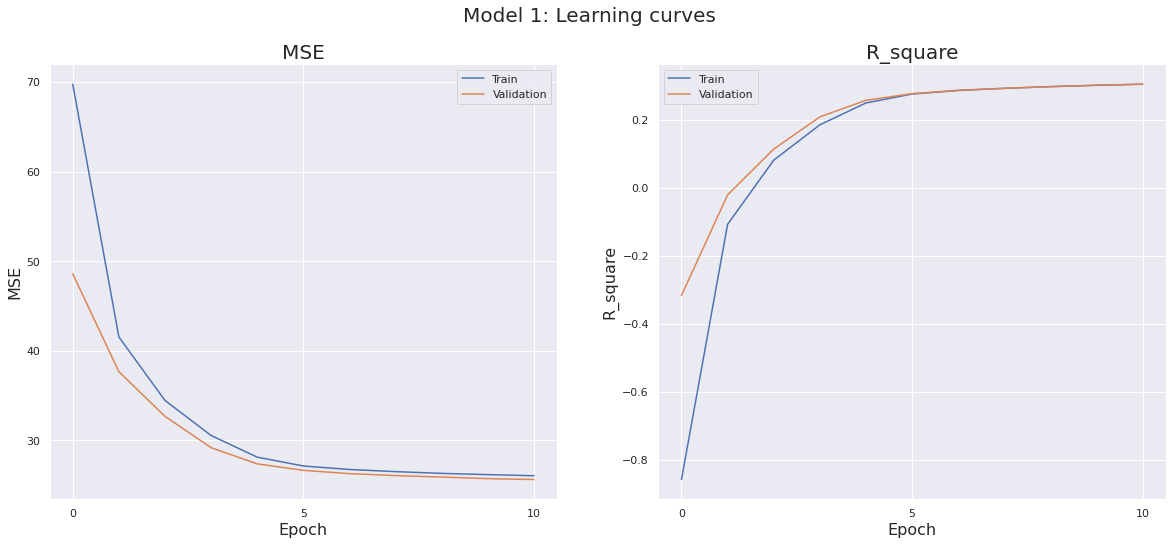

In [18]:
print_results(result)
plot_results(history, 'Model 1')

Hacemos un modelo más complicado. 

#### Model 2

In [19]:
model = Sequential()
model.add(Dense(3*n_inputs, input_dim = n_inputs, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4*n_inputs, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(n_inputs, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=tfa.metrics.RSquare())
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 27)                270       
                                                                 
 dropout (Dropout)           (None, 27)                0         
                                                                 
 dense_3 (Dense)             (None, 36)                1008      
                                                                 
 dropout_1 (Dropout)         (None, 36)                0         
                                                                 
 dense_4 (Dense)             (None, 9)                 333       
                                                                 
 dense_5 (Dense)             (None, 1)                 10        
                                                                 
Total params: 1,621
Trainable params: 1,621
Non-traina

In [20]:
epochs = 32
batch_size = 200

history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2);
result = model.evaluate(x_test,y_test)
clear_output()

Resulting MSE: 22.38


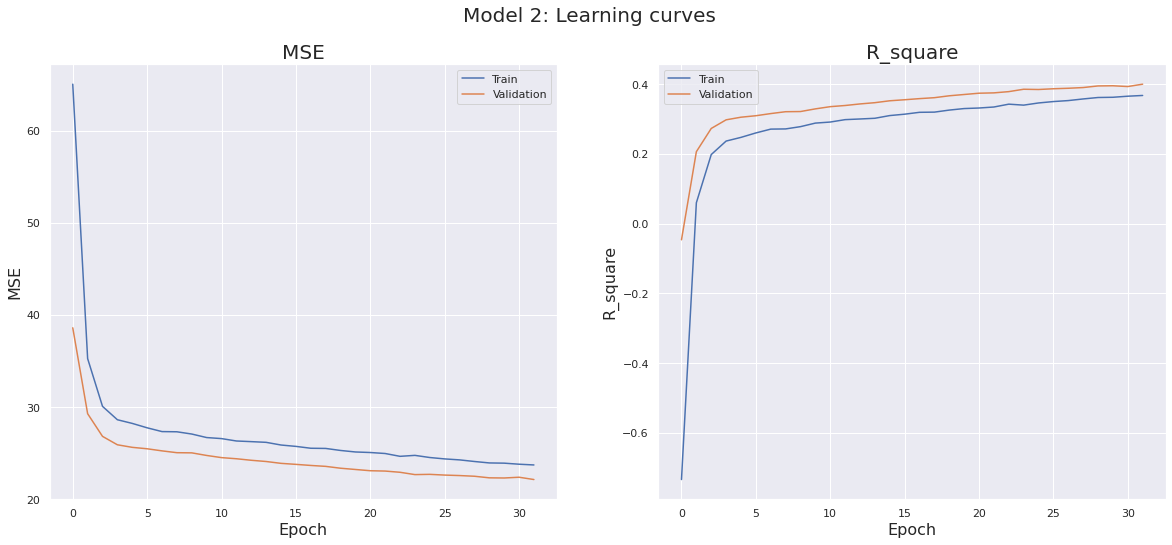

In [21]:
print_results(result)
plot_results(history, 'Model 2')

Tenemos valores mejores. 

#### Model 3

In [22]:
model3 = Sequential()
model3.add(Dense(20*n_inputs, input_dim = n_inputs, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(30*n_inputs, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(10*n_inputs, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(10*n_inputs, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(1, activation='linear'))

model3.compile(loss='mse', optimizer='adam', metrics=tfa.metrics.RSquare())
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 180)               1800      
                                                                 
 dropout_2 (Dropout)         (None, 180)               0         
                                                                 
 dense_7 (Dense)             (None, 270)               48870     
                                                                 
 dropout_3 (Dropout)         (None, 270)               0         
                                                                 
 dense_8 (Dense)             (None, 90)                24390     
                                                                 
 dropout_4 (Dropout)         (None, 90)                0         
                                                                 
 dense_9 (Dense)             (None, 90)               

In [23]:
epochs = 70
batch_size = 200

history3 = model3.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2);
result3 = model3.evaluate(x_test,y_test)
clear_output()

Resulting MSE: 14.488


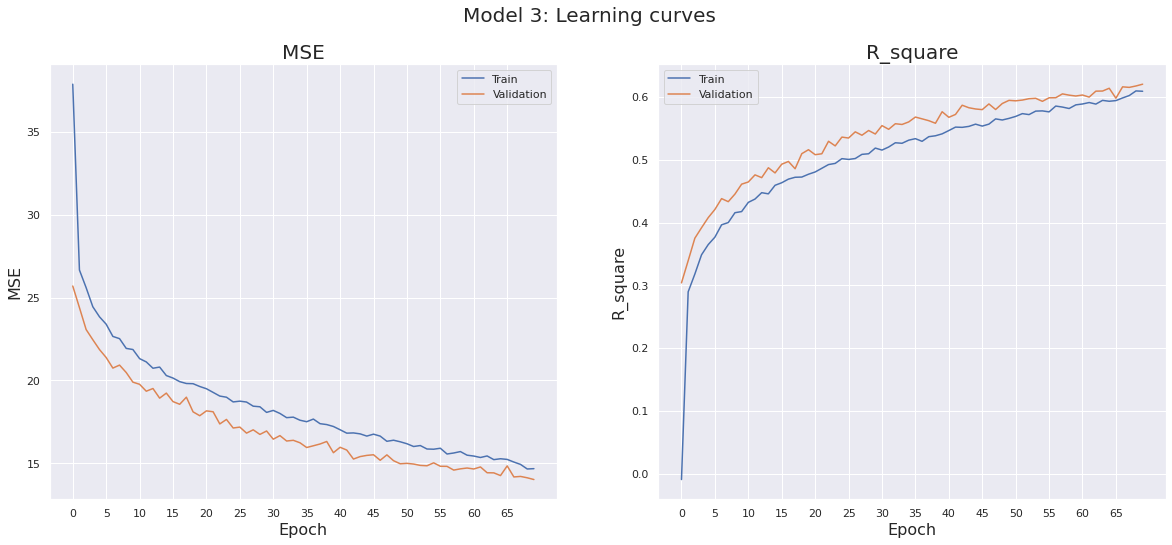

In [24]:
print_results(result3)
plot_results(history3, 'Model 3')

Vemos que tenemos un MSE mucho mejor que antes, y tambien un R-squared mejor. Todavia no tenemos un overfit, que vemos porque los valores del training set son parecidos como del validation set. Hacemos un más complicado. 

#### Modelo 4

In [25]:
model = Sequential()
model.add(Dense(20*n_inputs, input_dim = n_inputs, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50*n_inputs, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(40*n_inputs, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(30*n_inputs, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10*n_inputs, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=tfa.metrics.RSquare())
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 180)               1800      
                                                                 
 dropout_6 (Dropout)         (None, 180)               0         
                                                                 
 dense_12 (Dense)            (None, 450)               81450     
                                                                 
 dropout_7 (Dropout)         (None, 450)               0         
                                                                 
 dense_13 (Dense)            (None, 360)               162360    
                                                                 
 dropout_8 (Dropout)         (None, 360)               0         
                                                                 
 dense_14 (Dense)            (None, 270)              

In [26]:
epochs = 70
batch_size = 200

history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2);
result = model.evaluate(x_test,y_test)
clear_output()

Resulting MSE: 13.792


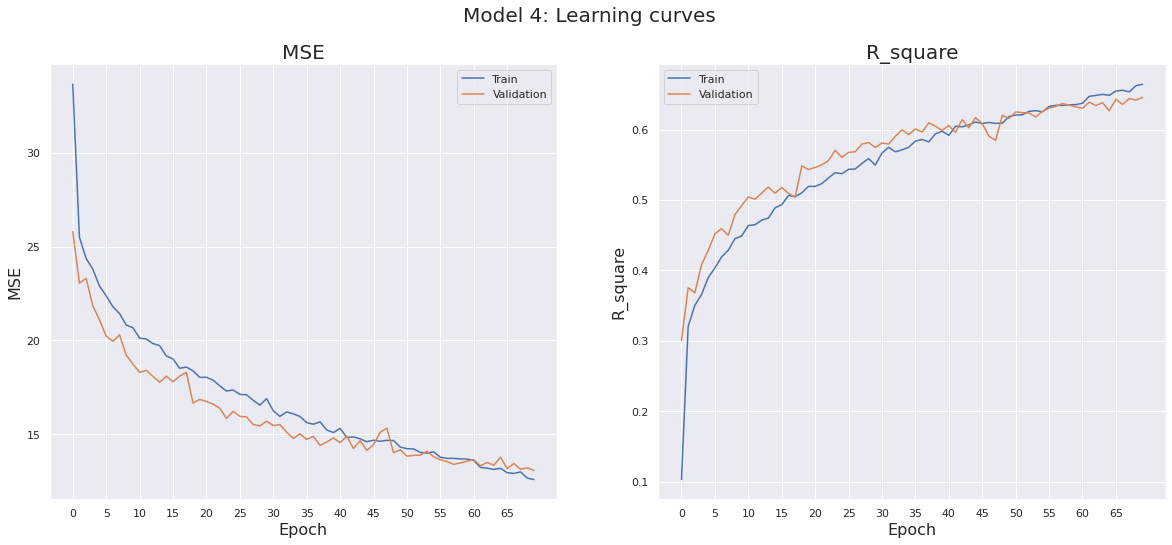

In [27]:
print_results(result)
plot_results(history, 'Model 4')

Ahora tenemos un pocito de overfit, pero todavia tenemos un MSE mejor que antes. 

#### Conclusion

Modelo 3 es mejor, porque lo hice con menor tiempo y tiene un MSE parecido de modelo 4. Hemos visto que un modelo más complicado no significa mejor resultados y que no es seguro que puedes hacer un modelo perfecto. 

In [28]:
# Función para graficar los resultados
def plot_final_results(y_pred, Y):
  fig, ax = plt.subplots(figsize = (15, 8))
  ax.plot(y_pred)
  ax.plot(Y)
  ax.set_title('Prediction',size=20)
  ax.set_ylabel('MSE',size=16)
  ax.set_xticks(range(0,len(y_pred),10000))
  ax.legend(['Prediction','Real value'], loc='upper right')
  plt.show()

In [29]:
y_pred = model3.predict(X) 

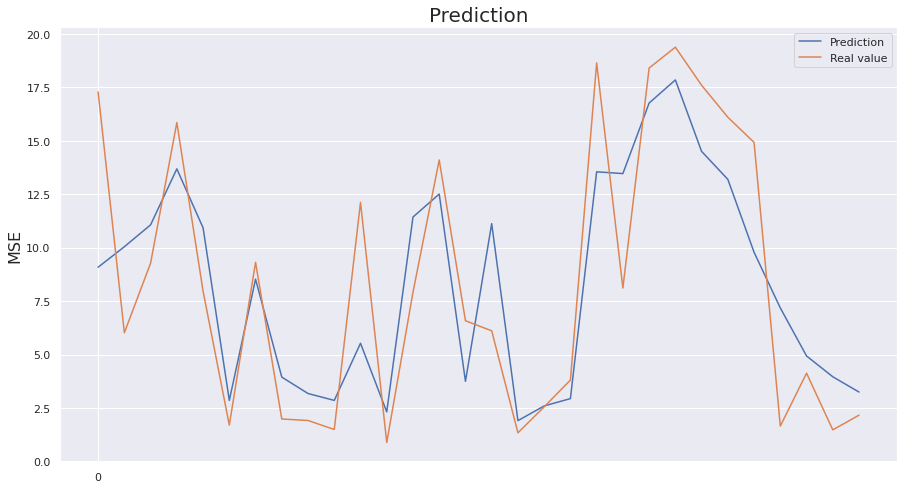

In [30]:
plot_final_results(y_pred[0:30],Y[0:30])

Arriba tenemos los treinta primeros predicciones. Vemos que el prediction no es perfecto, pero parece como los valores reales. 